<a href="https://colab.research.google.com/github/emmenets/neuralnetwork/blob/master/190910_rastionlydetectionandbluemarkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 30585, done.
remote: Total 30585 (delta 0), reused 0 (delta 0), pack-reused 30585
Receiving objects: 100% (30585/30585), 510.45 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (19224/19224), done.
Checking out files: 100% (3060/3060), done.


In [3]:
cd /content/models/research/

/content/models/research


In [4]:
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/model_lib_test.py -> build/lib/object_detection
copying object_detection/__init__.py -> build/lib/object_detection
copying object_detection/model_lib_v2_test.py -> build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph.py -> build/lib/object_detection
copying object_detection/exporter_test.py -> build/lib/object_detection
copying object_detecti

In [0]:
!cp -R /content/models/research/slim/nets /content/models/research/object_detection
!cp -R /content/models/research/slim/deployment /content/models/research/object_detection

In [6]:
cd /content/models/research/object_detection


/content/models/research/object_detection


In [11]:
######## Video Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/16/18
# Description: 
# This program uses a TensorFlow-trained classifier to perform object detection.
# It loads the classifier uses it to perform object detection on a video.
# It draws boxes and scores around the objects of interest in each frame
# of the video.

## Some of the code is copied from Google's example at
## https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

## and some is copied from Dat Tran's example at
## https://github.com/datitran/object_detector_app/blob/master/object_detection_app.py

## but I changed it to make it more understandable to me.

# Import packages
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import sys
import imutils
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import collections
import glob
import csv


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = '/gdrive/My Drive/colabfiles/lektion31/inference_graph'
VIDEO_NAME = '/gdrive/My Drive/colabfiles/lektion31/IMG_4001.MOV'


# Grab path to current working directory
CWD_PATH = os.getcwd()

print(CWD_PATH)

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = "/gdrive/My Drive/colabfiles/lektion31/inference_graph/frozen_inference_graph.pb"

# Path to label map file
PATH_TO_LABELS = "/gdrive/My Drive/colabfiles/lektion31/label_map.pbtxt"

# Path to video
PATH_TO_VIDEO = os.path.join(CWD_PATH,VIDEO_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')



/content/models/research/object_detection


In [0]:
def prozessvideo(image):
  #image = cv2.imread("/gdrive/My Drive/colabfiles/lektion20/IMG_4111.jpg")
  blurred = cv2.GaussianBlur(image, (11,11),0)
  hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
  (h, w, d) = image.shape
  lower_blue = np.array([100, 100, 120])
  upper_blue = np.array([130, 255, 255])
  mask = cv2.inRange(hsv, lower_blue, upper_blue)
  #mask = cv2.erode(mask, None, iterations=2)
  #mask = cv2.dilate(mask, None, iterations=2)


  # find contours in the mask and initialize the current
    # (x, y) center of the ball
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  pts = np.array([])
  print(cnts)

  
  anzdet = 0
  #print(cnts)
  
  # only proceed if at least one contour was found
  #if len(cnts) > 0:
  xkoords = []
  ykoords = []
  koordindex = 0
  

  for c in cnts:
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    
    # find the largest contour in the mask, then use
    # it to compute the minimum enclosing circle and
    # centroid
    #c = max(cnts, key=cv2.contourArea)
    #print(c)
    if radius > 1:
      anzdet += 1
      cv2.circle(image, (int(x),int(y)), 50, (0,255,0), -1)
      #print(radius)
      xkoords.append(int(x))
      ykoords.append(int(y))
      
      newrow = (int(x),int(y))
      pts = np.append(pts, newrow)
      
      

  # update the points queue
  #pts.appendleft(center)

  if 3 > 2:
    
    image = cv2.polylines(image,np.int32([np.reshape(pts, (int(len(pts)/2),2))]) ,1, (0,255,0), 3)
    
    mask = imutils.resize(mask, 400)
    image = imutils.resize(image, 400)
  return(image, mask)

    
    #cv2_imshow(mask)
    #cv2_imshow(image)    


Detect on Video

[]
0
86 435 132 506 : 47.9319304227829


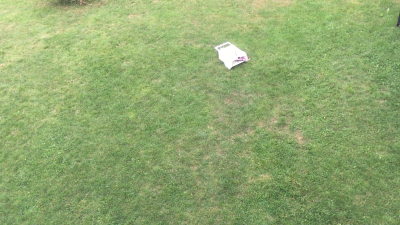

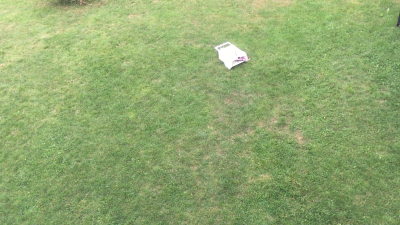

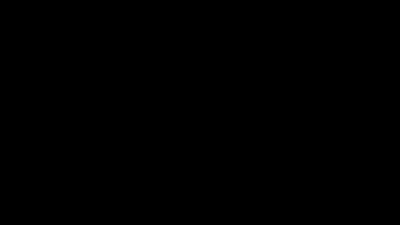

KeyboardInterrupt: ignored

In [33]:
# Open video file
video = cv2.VideoCapture(PATH_TO_VIDEO)
print("ok")
i = 0
bildverarbeitnr = 0
lasttime = time.time()
acttime = time.time()
bildnr = 0
while(video.isOpened()):
  #_, frame = video.read()
  frame = cv2.imread("/gdrive/My Drive/colabfiles/lektion20/bild.jpg")
  frame = imutils.resize(frame, 800)
  image, mask = prozessvideo(frame)
  frame_expanded = np.expand_dims(frame, axis=0)
  # Perform the actual detection by running the model with the image as input
  (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: frame_expanded})

  #print(boxes)
  try:
    box = np.squeeze(boxes)
    score = np.squeeze(scores)
    maxscore = max(enumerate(score), key=lambda x: x[1])[0]
    print(maxscore)
    height, width, _ = frame.shape
    ymin = (int(box[maxscore,0]*height))
    xmin = (int(box[maxscore,1]*width))
    ymax = (int(box[maxscore,2]*height))
    xmax = (int(box[maxscore,3]*width))
    genauigkeit = (score[maxscore])*100
    print(ymin,xmin,ymax,xmax,":",genauigkeit)
    if genauigkeit > 80:
      frame = cv2.rectangle(frame,(xmin,ymin), (xmax,ymax), (0,255,0),8)
      print(category_index)
  except:
    pass
  frame = imutils.resize(frame, 400)
  mask = imutils.resize(mask, 400)
  image = imutils.resize(image, 400)
  cv2_imshow(frame)
  cv2_imshow(image)
  cv2_imshow(mask)
  time.sleep(1)
  clear_output()
        
        
        #clear_output()
        

        # Press 'q' to quit
        #print(i)
        #i = i + 1
        #if cv2.waitKey(1) == ord('q'):
        #    break

# Clean up
print("end1")
#video.release()
#cv2.destroyAllWindows()
print("end2")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# New Section

# New Section